In [31]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
import torch
import math
import matplotlib.pyplot as plt
import einops as E
import random
import sys
from collections import defaultdict

sys.path.append('/home/t722s/Desktop/UniversalModels/OtherRepos/UniverSeg')
from universeg import universeg

In [80]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray', aspect = 'equal')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

def get_slices(volume_path, fg_label = None, size = (128,128)):
    '''
    Given a path to a nifti volume, obtain a list of slices, resizing them to the given resolution and return slices as a list of tensors
    '''
    volume = nib.load(volume_path).get_fdata()
    if fg_label: # If is a label, set all other entries to 0. Mostly useful for multisegmentation datasets. 
        volume[volume!= fg_label] = 0

    volume = torch.from_numpy(volume).float() # Universeg requries floats, not doubles.
    slices = torch.unbind(volume, dim = 2)

    # Resize slices if desired:
    if size:
        resize_factor = np.array(size)/np.array(slices[0].shape)
        order = 0 if fg_label else 1 # nearest neighbour interpolation for labels, bilinear for images

        slices = [torch.from_numpy(zoom(slice, resize_factor, order = order))
                        for slice in slices]

    return(slices)

def get_slices_resize3D(volume_path, sizeXY = (128,128)):
    '''
    As with get_slices, but rescales volumes rather than each slice. I thought this'd be quicker, but it seems to be slower and I'm not sure why.
    '''
    volume = nib.load(volume_path).get_fdata()

    # resize volume if desired
    if sizeXY:
        size = sizeXY + (volume.shape[2],)
        resize_factor = np.array(size)/np.array(volume.shape)
        volume = zoom(volume, resize_factor, order = 1)

    volume = torch.from_numpy(volume).float() # Universeg requries floats, not doubles.
    slices = torch.unbind(volume, dim = 2)


    return(slices)

def classify_list(l, delta = 3):
    '''
    Given a list of 1s and 0s (ie slices with foreground, slices with no foreground within a volume), return list of equal length classifying each element as 'bg', 'bgb', 'fgb' and 'fg', meaning background, background border, foreground border
    and foreground, with 'background border' meaning a 0 within delta of a 1, and similarly for 'foreground border'.
    '''

    n = len(l)
    classification = [''] * n

    for i in range(n):
        # Check if within delta indices, there's an element of the other type
        lower = max(i-delta, 0)
        upper = min(i+delta+1, n)
        
        is_border = any(l[j] != l[i] 
                        for j in range(lower, upper))

        if l[i] == 1:
            classification[i] = 'fgb' if is_border else 'fg'
        else:
            classification[i] = 'bgb' if is_border else 'bg'

    return classification  

def get_support_inds(l, num_of_slices = [1,1,1,1]): 
    '''
    Given a list l classified as by classify_list (distinguishing between foreground etc as 'bg', 'bgb', 'fgb', 'fg'), gets uniformly sampled indices for each class to use as indices for support slices. The number per class is defind by
    num_of_slices, representing the desired number of support slices from background, background border, foreground border and foreground respectively
    '''

    support_inds = []

    for i, cls in enumerate(['bg', 'bgb', 'fgb', 'fg']):
        n = num_of_slices[i]

        # Obtain sample n indices uniformly at random of type cls from l 
        cls_inds = [i for i, x in enumerate(l)  if x == cls] # ie the slice indices of type cls

        if n > l.count(cls):
            raise RuntimeError(f'Not enough slices of type {cls}')
        
        sampled_inds = random.sample(cls_inds, n)

        support_inds.extend(sampled_inds)

    return(support_inds)

def get_support_slices_labels(support_volume_paths, support_label_paths, fg_label, device):# Include infer label option for binary tasks
    '''
    The paths in support_volume_paths and support_label_paths must correspond. Returns (support_slices, support_labels).
    '''

    if len(support_volume_paths) != len(support_label_paths):
        raise RuntimeError(f'Unequal number of support volume paths and labels given, {len(support_volume_paths)}, {len(support_label_paths)} respectively')
    
    support_slices = []
    support_labels = []

    # Obtain support slices and their labels
    for i in range(len(support_volume_paths)):
        # Load in volumes and labels as tuples of tensors
        volume_slices = get_slices(support_volume_paths[i])
        label_slices = get_slices(support_label_paths[i], fg_label = fg_label)

        # Choose indices to use to select support slices and labels
        fg_present = [int(fg_label in slice) for slice in label_slices] 
        fg_present_nuanced = classify_list(fg_present)
        support_inds = get_support_inds(fg_present_nuanced)

        # obtain support slices and labels from support volumes and labels
        support_slices.extend([volume_slices[i][None] for i in support_inds])
        support_labels.extend([label_slices[i][None] for i in support_inds])

    support_slices = torch.stack(support_slices).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return (support_slices, support_labels)

def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

@torch.no_grad()
def inference(model, image, label, support_images, support_labels, device = 'cuda'):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [90]:
support_label_paths

['/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0001.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0004.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0005.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0006.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0007.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0008.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0009.nii.gz',
 '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/amos_0010.nii.gz']

In [98]:
fg_label = 2
label_slices = get_slices(support_label_paths[8])
fg_present = [int(fg_label in slice) for slice in label_slices] 
fg_present_nuanced = classify_list(fg_present)
fg_present_nuanced

IndexError: list index out of range

In [ ]:
# Configurable parameters 
device = 'cuda'

# Obtain support slices
volume_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTr/'
volume_paths = sorted([os.path.join(volume_dir, file) for file in os.listdir(volume_dir)]) # in later usage, if a random selection is desired, don't use sorted here, and use np.random.permutation later

label_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/'
label_paths = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir)])
# Split volumes, labels into support and query sets
# volume_paths, label_paths = np.random.permutation(volume_paths), np.random.permutation(label_paths)
n_support_volumes = 8
support_volume_paths,   query_volume_paths  = volume_paths[:n_support_volumes], volume_paths[n_support_volumes:]
support_label_paths,    query_label_paths   = label_paths[:n_support_volumes],  volume_paths[n_support_volumes:] 

support_slices = []
support_labels = []

# Obtain support slices and their labels
for i in range(len(support_volume_paths)):
    # Load in volumes and labels as tuples of tensors
    volume_slices = get_slices(support_volume_paths[i])
    label_slices = get_slices(support_label_paths[i], fg_label = 1)

    # Choose indices to use to select support slices and labels
    fg_present = [int(fg_label in slice) for slice in label_slices] 
    fg_present_nuanced = classify_list(fg_present)
    support_inds = get_support_inds(fg_present_nuanced)

    # obtain support slices and labels from support volumes and labels
    support_slices.extend([volume_slices[i][None] for i in support_inds])
    support_labels.extend([label_slices[i][None] for i in support_inds])

support_slices = torch.stack(support_slices).to(device)
support_labels = torch.stack(support_labels).to(device)

In [88]:
# Configurable parameters 
device = 'cuda'

# Obtain support slices
volume_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTr/'
volume_paths = sorted([os.path.join(volume_dir, file) for file in os.listdir(volume_dir)]) # in later usage, if a random selection is desired, don't use sorted here, and use np.random.permutation later

label_dir = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTr/'
label_paths = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir)])
# Split volumes, labels into support and query sets
# volume_paths, label_paths = np.random.permutation(volume_paths), np.random.permutation(label_paths)
n_support_volumes = 8
support_volume_paths,   query_volume_paths  = volume_paths[:n_support_volumes], volume_paths[n_support_volumes:]
support_label_paths,    query_label_paths   = label_paths[:n_support_volumes],  volume_paths[n_support_volumes:] 


support_slices, support_labels = get_support_slices_labels(support_volume_paths, support_label_paths, fg_label = 2, device = device)


visualize_tensors({
    'support images': support_slices[:8],
    'support labels': support_labels[:8]
})

RuntimeError: Not enough slices of type bgb

In [9]:
# Perform inference:
model = universeg(pretrained=True).to(device)

# load in query volume and label
i = 0
query_volume_path = support_volume_paths
query_label_path = 'HaN_OAR/9/label.nii.gz'

query_volume_slices = get_slices(query_volume_path)
query_label_slices = get_slices(query_label_path)


In [10]:
idx = 20
slice = query_volume_slices[idx][None].to(device) # Include None to add 1 dimensional color channel
label = query_label_slices[idx][None].to(device)

logits = model(slice[None], support_slices[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

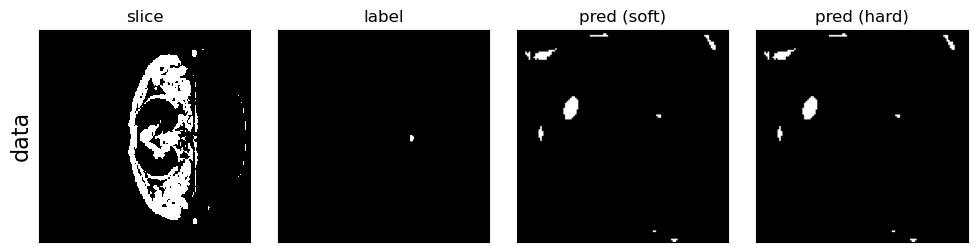

In [29]:
res = {'data': [slice, label, pred, pred > 0.5]}
titles = col_names=['slice', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)